In [2]:
import sys
sys.path.append('../../..')  # Add project root to path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pickle
from typing import Dict, List, Tuple

# Import project modules
from src.config import Config, load_model_and_tokenizer
from src.datasets import TemporalDatasetCreator, get_control_words
from src.embeddings import extract_all_layer_representations, extract_control_embeddings
from src.utils import check_gpu_availability, set_random_seeds

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seeds for reproducibility
set_random_seeds(42)


Random seeds set to 42


In [3]:
# Initialize configuration
config = Config()
print(f"Using device: {config.device}")

# Load model and tokenizer
model, tokenizer = load_model_and_tokenizer(config)
print(f"Loaded model: {config.model_name}")
print(f"Number of layers: {model.config.num_hidden_layers + 1}")  # +1 for embedding layer


Using device: cpu
Loading model: meta-llama/Llama-3.2-1B
Loaded model: meta-llama/Llama-3.2-1B
Number of layers: 17


In [4]:
# Create temporal dataset (add_plur)
creator = TemporalDatasetCreator(config)
# create_dataset returns a list, we need to filter for add_plur context
all_data = creator.create_dataset(['add_plur'])  # Only create add_plur data
add_plur_df = pd.DataFrame(all_data)
print(f"Temporal dataset size: {len(add_plur_df)}")
print(f"Sample temporal examples:")
print(add_plur_df.head())

# Get control words
control_words = get_control_words()
print(f"\nControl words: {len(control_words)} words")
print(f"Categories: food, emotions, actions, descriptions, etc.")
print(f"Sample control words: {control_words[:10]}")


Temporal dataset size: 413
Sample temporal examples:
                                  text  day  offset  result_day   context
0  Monday plus 2 days equals Wednesday    0       2           2  add_plur
1   Monday plus 3 days equals Thursday    0       3           3  add_plur
2     Monday plus 4 days equals Friday    0       4           4  add_plur
3   Monday plus 5 days equals Saturday    0       5           5  add_plur
4     Monday plus 6 days equals Sunday    0       6           6  add_plur

Control words: 45 words
Categories: food, emotions, actions, descriptions, etc.
Sample control words: ['apple', 'banana', 'orange', 'grape', 'strawberry', 'carrot', 'broccoli', 'potato', 'tomato', 'lettuce']


In [5]:
# Import TemporalDataset class
from src.datasets import TemporalDataset

# Extract temporal embeddings
print("Extracting temporal embeddings from all layers...")

# Tokenize temporal texts
temporal_texts = add_plur_df['text'].tolist()
temporal_encodings = tokenizer(temporal_texts, truncation=True, padding=True, return_tensors='pt', max_length=128)

# Create PyTorch dataset
temporal_dataset = TemporalDataset(temporal_encodings, add_plur_df)

# Extract embeddings from all layers
temporal_embeddings, temporal_labels = extract_all_layer_representations(
    model, temporal_dataset, config.device, batch_size=config.batch_size
)

# Extract control embeddings
print("\nExtracting control embeddings from all layers...")
control_embeddings, control_labels = extract_control_embeddings(
    control_words, model, tokenizer, config.device
)

print(f"\nExtraction complete!")
print(f"Layers analyzed: {len(temporal_embeddings)}")
print(f"Temporal embedding shape (layer 0): {temporal_embeddings[0].shape}")
print(f"Control embedding shape (layer 0): {control_embeddings[0].shape}")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Extracting temporal embeddings from all layers...


Extracting representations:   0%|          | 0/26 [00:00<?, ?it/s]/Users/kadenzheng/manifolds/notebooks/analysis/variance_explained/../../../src/datasets.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Extracting representations: 100%|██████████| 26/26 [00:05<00:00,  5.08it/s]



Extracting control embeddings from all layers...


Extracting representations:   0%|          | 0/2 [00:00<?, ?it/s]/Users/kadenzheng/manifolds/notebooks/analysis/variance_explained/../../../src/datasets.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Extracting representations: 100%|██████████| 2/2 [00:00<00:00,  5.41it/s]


Extraction complete!
Layers analyzed: 17
Temporal embedding shape (layer 0): (413, 2048)
Control embedding shape (layer 0): (45, 2048)


In [6]:
def analyze_variance_explained(embeddings: np.ndarray, max_components: int = None) -> Dict:
    """
    Analyze variance explained by PCA components.
    
    Args:
        embeddings: Input embeddings
        max_components: Maximum number of components to compute (None = all)
        
    Returns:
        dict: Analysis results including variance ratios and cumulative variance
    """
    # Standardize the data
    scaler = StandardScaler()
    embeddings_scaled = scaler.fit_transform(embeddings)
    
    # Determine number of components
    n_samples, n_features = embeddings.shape
    n_components = min(n_samples, n_features)
    if max_components is not None:
        n_components = min(n_components, max_components)
    
    # Perform PCA
    pca = PCA(n_components=n_components)
    pca.fit(embeddings_scaled)
    
    # Calculate cumulative variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    
    # Find components needed for different thresholds
    thresholds = [0.80, 0.90, 0.95, 0.99]
    components_needed = {}
    for threshold in thresholds:
        idx = np.argmax(cumulative_variance >= threshold)
        if cumulative_variance[idx] >= threshold:
            components_needed[threshold] = idx + 1
        else:
            components_needed[threshold] = n_components
    
    return {
        'variance_ratios': pca.explained_variance_ratio_,
        'cumulative_variance': cumulative_variance,
        'components_needed': components_needed,
        'total_components': n_components,
        'embedding_dim': n_features
    }


In [7]:
# Analyze variance for all layers
temporal_variance_results = {}
control_variance_results = {}

print("Analyzing variance explained across layers...\n")

for layer_idx in temporal_embeddings.keys():
    # Analyze temporal data
    temporal_results = analyze_variance_explained(temporal_embeddings[layer_idx], max_components=100)
    temporal_variance_results[layer_idx] = temporal_results
    
    # Analyze control data
    control_results = analyze_variance_explained(control_embeddings[layer_idx], max_components=100)
    control_variance_results[layer_idx] = control_results
    
    # Print summary for this layer
    print(f"Layer {layer_idx}:")
    print(f"  Embedding dimension: {temporal_results['embedding_dim']}")
    print(f"  Components for 95% variance:")
    print(f"    - Temporal: {temporal_results['components_needed'][0.95]}")
    print(f"    - Control: {control_results['components_needed'][0.95]}")
    print()


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/pyth

Analyzing variance explained across layers...

Layer 0:
  Embedding dimension: 2048
  Components for 95% variance:
    - Temporal: 6
    - Control: 2

Layer 1:
  Embedding dimension: 2048
  Components for 95% variance:
    - Temporal: 6
    - Control: 18

Layer 2:
  Embedding dimension: 2048
  Components for 95% variance:
    - Temporal: 7
    - Control: 30

Layer 3:
  Embedding dimension: 2048
  Components for 95% variance:
    - Temporal: 10
    - Control: 30

Layer 4:
  Embedding dimension: 2048
  Components for 95% variance:
    - Temporal: 16
    - Control: 30

Layer 5:
  Embedding dimension: 2048
  Components for 95% variance:
    - Temporal: 24
    - Control: 32

Layer 6:
  Embedding dimension: 2048
  Components for 95% variance:
    - Temporal: 26
    - Control: 32

Layer 7:
  Embedding dimension: 2048
  Components for 95% variance:
    - Temporal: 29
    - Control: 31

Layer 8:
  Embedding dimension: 2048
  Components for 95% variance:
    - Temporal: 29
    - Control: 31



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/pyth

Layer 9:
  Embedding dimension: 2048
  Components for 95% variance:
    - Temporal: 29
    - Control: 30

Layer 10:
  Embedding dimension: 2048
  Components for 95% variance:
    - Temporal: 27
    - Control: 29

Layer 11:
  Embedding dimension: 2048
  Components for 95% variance:
    - Temporal: 24
    - Control: 28

Layer 12:
  Embedding dimension: 2048
  Components for 95% variance:
    - Temporal: 24
    - Control: 29

Layer 13:
  Embedding dimension: 2048
  Components for 95% variance:
    - Temporal: 25
    - Control: 29

Layer 14:
  Embedding dimension: 2048
  Components for 95% variance:
    - Temporal: 24
    - Control: 29

Layer 15:
  Embedding dimension: 2048
  Components for 95% variance:
    - Temporal: 25
    - Control: 30

Layer 16:
  Embedding dimension: 2048
  Components for 95% variance:
    - Temporal: 33
    - Control: 30



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:590: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:590: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:590: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extma

In [8]:
# Create summary dataframe
summary_data = []

for layer_idx in temporal_embeddings.keys():
    temporal_res = temporal_variance_results[layer_idx]
    control_res = control_variance_results[layer_idx]
    
    summary_data.append({
        'Layer': layer_idx,
        'Embedding_Dim': temporal_res['embedding_dim'],
        'Temporal_95%': temporal_res['components_needed'][0.95],
        'Control_95%': control_res['components_needed'][0.95],
        'Temporal_90%': temporal_res['components_needed'][0.90],
        'Control_90%': control_res['components_needed'][0.90],
        'Temporal_99%': temporal_res['components_needed'][0.99],
        'Control_99%': control_res['components_needed'][0.99],
        'Temporal_Ratio_95%': temporal_res['components_needed'][0.95] / temporal_res['embedding_dim'],
        'Control_Ratio_95%': control_res['components_needed'][0.95] / control_res['embedding_dim']
    })

summary_df = pd.DataFrame(summary_data)
print("\nSummary of components needed for 95% variance:")
print(summary_df[['Layer', 'Embedding_Dim', 'Temporal_95%', 'Control_95%', 
                  'Temporal_Ratio_95%', 'Control_Ratio_95%']])



Summary of components needed for 95% variance:
    Layer  Embedding_Dim  Temporal_95%  Control_95%  Temporal_Ratio_95%  \
0       0           2048             6            2            0.002930   
1       1           2048             6           18            0.002930   
2       2           2048             7           30            0.003418   
3       3           2048            10           30            0.004883   
4       4           2048            16           30            0.007812   
5       5           2048            24           32            0.011719   
6       6           2048            26           32            0.012695   
7       7           2048            29           31            0.014160   
8       8           2048            29           31            0.014160   
9       9           2048            29           30            0.014160   
10     10           2048            27           29            0.013184   
11     11           2048            24           28 

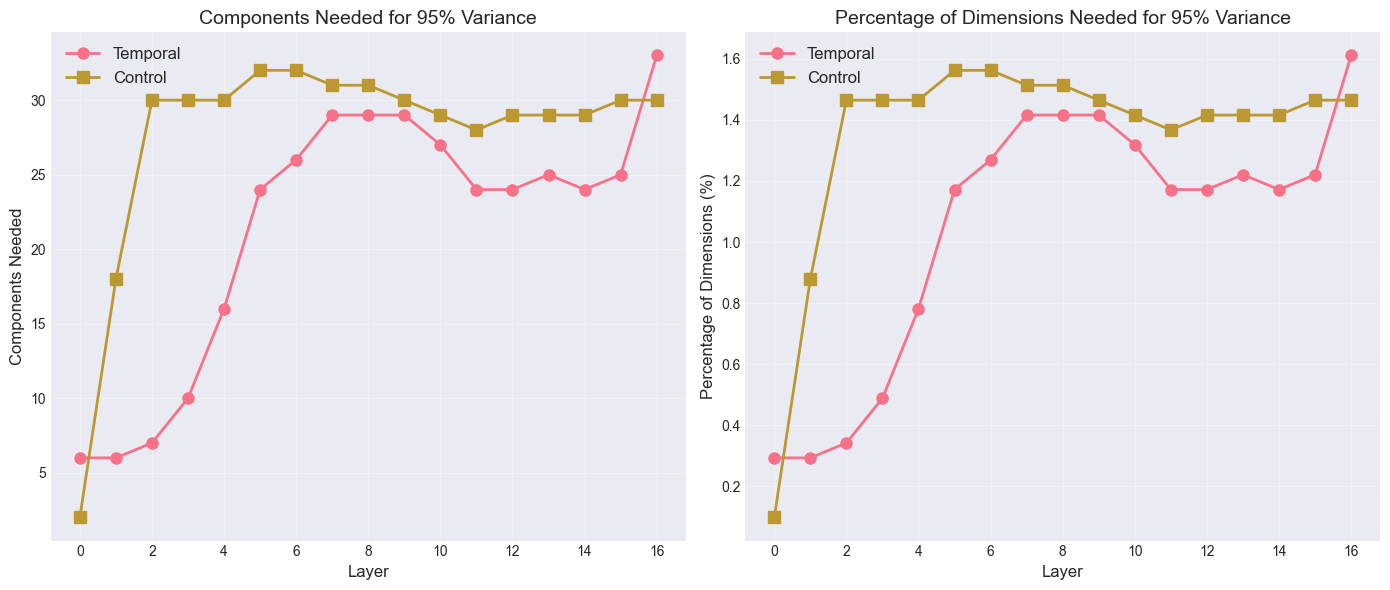

In [9]:
# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot absolute number of components
layers = summary_df['Layer'].values
ax1.plot(layers, summary_df['Temporal_95%'], 'o-', label='Temporal', linewidth=2, markersize=8)
ax1.plot(layers, summary_df['Control_95%'], 's-', label='Control', linewidth=2, markersize=8)
ax1.set_xlabel('Layer', fontsize=12)
ax1.set_ylabel('Components Needed', fontsize=12)
ax1.set_title('Components Needed for 95% Variance', fontsize=14)
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)

# Plot ratio of components to embedding dimension
ax2.plot(layers, summary_df['Temporal_Ratio_95%'] * 100, 'o-', label='Temporal', linewidth=2, markersize=8)
ax2.plot(layers, summary_df['Control_Ratio_95%'] * 100, 's-', label='Control', linewidth=2, markersize=8)
ax2.set_xlabel('Layer', fontsize=12)
ax2.set_ylabel('Percentage of Dimensions (%)', fontsize=12)
ax2.set_title('Percentage of Dimensions Needed for 95% Variance', fontsize=14)
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../../results/figures/variance_analysis/components_needed_95_variance.png', dpi=300, bbox_inches='tight')
plt.show()


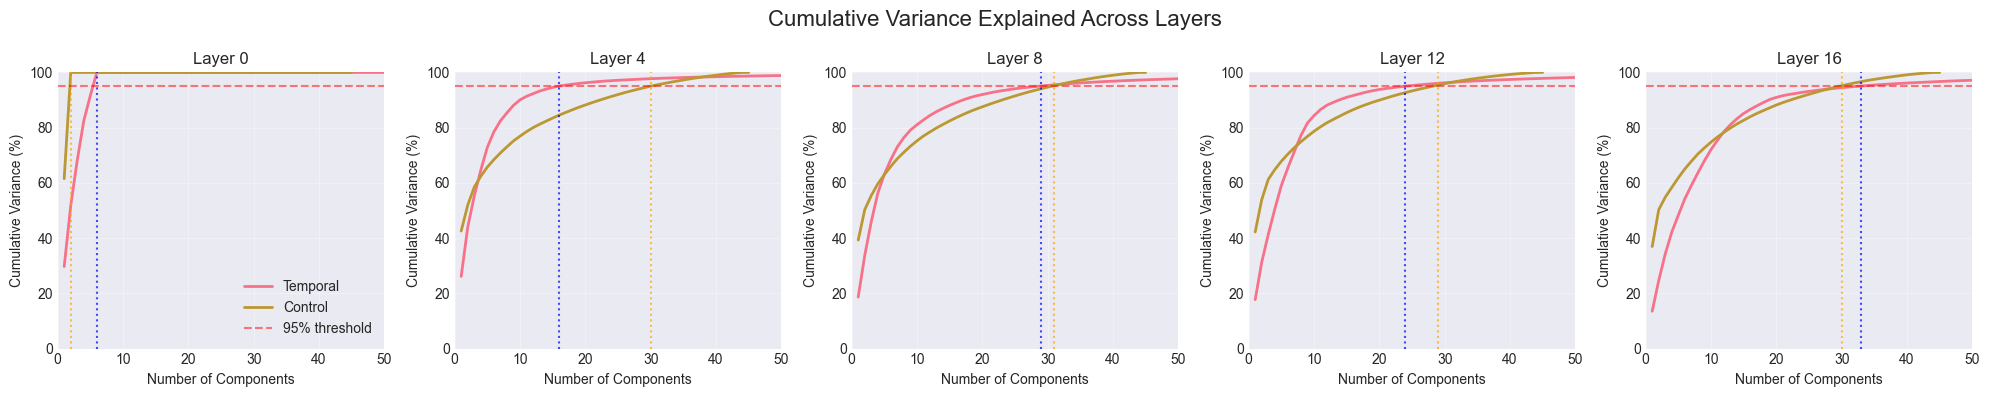

In [10]:
# Select representative layers
selected_layers = [0, 4, 8, 12, 16]

fig, axes = plt.subplots(1, len(selected_layers), figsize=(20, 4))

for idx, layer in enumerate(selected_layers):
    ax = axes[idx]
    
    # Get cumulative variance for first 50 components
    temporal_cumvar = temporal_variance_results[layer]['cumulative_variance'][:50]
    control_cumvar = control_variance_results[layer]['cumulative_variance'][:50]
    
    # Plot cumulative variance
    ax.plot(range(1, len(temporal_cumvar) + 1), temporal_cumvar * 100, 
            label='Temporal', linewidth=2)
    ax.plot(range(1, len(control_cumvar) + 1), control_cumvar * 100, 
            label='Control', linewidth=2)
    
    # Add 95% threshold line
    ax.axhline(y=95, color='red', linestyle='--', alpha=0.5, label='95% threshold')
    
    # Add vertical lines for components needed
    temporal_95 = temporal_variance_results[layer]['components_needed'][0.95]
    control_95 = control_variance_results[layer]['components_needed'][0.95]
    
    if temporal_95 <= 50:
        ax.axvline(x=temporal_95, color='blue', linestyle=':', alpha=0.7)
    if control_95 <= 50:
        ax.axvline(x=control_95, color='orange', linestyle=':', alpha=0.7)
    
    ax.set_xlabel('Number of Components')
    ax.set_ylabel('Cumulative Variance (%)')
    ax.set_title(f'Layer {layer}')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 50)
    ax.set_ylim(0, 100)
    
    if idx == 0:
        ax.legend()

plt.suptitle('Cumulative Variance Explained Across Layers', fontsize=16)
plt.tight_layout()
plt.savefig('../../../results/figures/variance_analysis/cumulative_variance_curves.png', dpi=300, bbox_inches='tight')
plt.show()


In [11]:
# Create interactive plotly visualization with improved layout
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        'Components for Variance Thresholds',
        'Dimension Percentage (95% var)',
        'Cumulative Variance - Layer 8',
        'First PC Variance by Layer'
    ),
    vertical_spacing=0.25,  # Increased spacing
    horizontal_spacing=0.15  # Increased spacing
)

# Color scheme for better visual clarity
temporal_color = '#1f77b4'  # Blue
control_color = '#ff7f0e'   # Orange
threshold_colors = {'90': '#2ca02c', '95': '#d62728', '99': '#9467bd'}

# Subplot 1: Components needed - only show 95% threshold for clarity
threshold = 0.95
temporal_components = [temporal_variance_results[l]['components_needed'][threshold] for l in layers]
control_components = [control_variance_results[l]['components_needed'][threshold] for l in layers]

fig.add_trace(
    go.Scatter(x=layers, y=temporal_components, 
               name='Temporal',
               mode='lines+markers',
               line=dict(color=temporal_color, width=3),
               marker=dict(size=8)),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=layers, y=control_components, 
               name='Control',
               mode='lines+markers',
               line=dict(color=control_color, width=3, dash='dash'),
               marker=dict(size=8)),
    row=1, col=1
)

# Add shaded regions for 90% and 99% thresholds
for thresh_val, thresh_label in [(0.90, '90%'), (0.99, '99%')]:
    temp_comp = [temporal_variance_results[l]['components_needed'][thresh_val] for l in layers]
    fig.add_trace(
        go.Scatter(x=layers, y=temp_comp,
                   name=f'Temporal {thresh_label}',
                   mode='lines',
                   line=dict(color=temporal_color, width=1),
                   opacity=0.4,
                   showlegend=False),
        row=1, col=1
    )

# Subplot 2: Ratio for 95% variance
fig.add_trace(
    go.Scatter(x=layers, y=summary_df['Temporal_Ratio_95%'] * 100,
               name='Temporal %',
               mode='lines+markers',
               line=dict(color=temporal_color, width=3),
               marker=dict(size=10)),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(x=layers, y=summary_df['Control_Ratio_95%'] * 100,
               name='Control %',
               mode='lines+markers',
               line=dict(color=control_color, width=3),
               marker=dict(size=10)),
    row=1, col=2
)

# Subplot 3: Cumulative variance for middle layer
middle_layer = 8
components = range(1, 51)
temporal_cumvar = temporal_variance_results[middle_layer]['cumulative_variance'][:50] * 100
control_cumvar = control_variance_results[middle_layer]['cumulative_variance'][:50] * 100

fig.add_trace(
    go.Scatter(x=list(components), y=temporal_cumvar,
               name='Temporal',
               mode='lines',
               line=dict(color=temporal_color, width=3)),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=list(components), y=control_cumvar,
               name='Control',
               mode='lines',
               line=dict(color=control_color, width=3)),
    row=2, col=1
)

# Add 95% threshold line with annotation
fig.add_hline(y=95, row=2, col=1, 
              line_dash="dash", 
              line_color="red", 
              opacity=0.7,
              annotation_text="95%",
              annotation_position="right")

# Add vertical lines showing where each curve crosses 95%
temp_95_idx = temporal_variance_results[middle_layer]['components_needed'][0.95]
ctrl_95_idx = control_variance_results[middle_layer]['components_needed'][0.95]

fig.add_vline(x=temp_95_idx, row=2, col=1,
              line_dash="dot", 
              line_color=temporal_color, 
              opacity=0.5)
fig.add_vline(x=ctrl_95_idx, row=2, col=1,
              line_dash="dot", 
              line_color=control_color, 
              opacity=0.5)

# Subplot 4: First PC variance
first_pc_temporal = [temporal_variance_results[l]['variance_ratios'][0] * 100 for l in layers]
first_pc_control = [control_variance_results[l]['variance_ratios'][0] * 100 for l in layers]

fig.add_trace(
    go.Scatter(x=layers, y=first_pc_temporal,
               name='Temporal 1st PC',
               mode='lines+markers',
               line=dict(color=temporal_color, width=3),
               marker=dict(size=8)),
    row=2, col=2
)
fig.add_trace(
    go.Scatter(x=layers, y=first_pc_control,
               name='Control 1st PC',
               mode='lines+markers',
               line=dict(color=control_color, width=3),
               marker=dict(size=8)),
    row=2, col=2
)

# Update axes with better formatting
fig.update_xaxes(title_text="Layer", title_font=dict(size=14), row=1, col=1)
fig.update_xaxes(title_text="Layer", title_font=dict(size=14), row=1, col=2)
fig.update_xaxes(title_text="Components", title_font=dict(size=14), row=2, col=1)
fig.update_xaxes(title_text="Layer", title_font=dict(size=14), row=2, col=2)

fig.update_yaxes(title_text="# Components", title_font=dict(size=14), row=1, col=1)
fig.update_yaxes(title_text="% of Dimensions", title_font=dict(size=14), row=1, col=2)
fig.update_yaxes(title_text="Cumulative Var. (%)", title_font=dict(size=14), row=2, col=1)
fig.update_yaxes(title_text="Variance (%)", title_font=dict(size=14), row=2, col=2)

# Update layout with improved styling
fig.update_layout(
    height=1100,  # Increased height
    width=1200,   # Set width for better proportions
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5,
        font=dict(size=12)
    ),
    title=dict(
        text="PCA Variance Analysis: Temporal vs Control Data",
        font=dict(size=20),
        x=0.5,
        xanchor='center'
    ),
    hovermode='x unified',
    plot_bgcolor='white',
    font=dict(size=12)
)

# Update subplot titles font size
for annotation in fig['layout']['annotations']:
    annotation['font'] = dict(size=16)

# Add grid lines for better readability
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

# Save interactive plot
fig.write_html('../../../results/html/variance_explained_interactive.html')
fig.show()


In [12]:
# Import TemporalDataset class
from src.datasets import TemporalDataset

# Extract temporal embeddings
print("Extracting temporal embeddings from all layers...")

# Tokenize temporal texts
temporal_texts = add_plur_df['text'].tolist()
temporal_encodings = tokenizer(temporal_texts, truncation=True, padding=True, return_tensors='pt', max_length=128)

# Create PyTorch dataset
temporal_dataset = TemporalDataset(temporal_encodings, add_plur_df)

# Extract embeddings from all layers
temporal_embeddings, temporal_labels = extract_all_layer_representations(
    model, temporal_dataset, config.device, batch_size=config.batch_size
)

# Extract control embeddings
print("\nExtracting control embeddings from all layers...")
control_embeddings, control_labels = extract_control_embeddings(
    control_words, model, tokenizer, config.device
)

print(f"\nExtraction complete!")
print(f"Layers analyzed: {len(temporal_embeddings)}")
print(f"Temporal embedding shape (layer 0): {temporal_embeddings[0].shape}")
print(f"Control embedding shape (layer 0): {control_embeddings[0].shape}")


Extracting temporal embeddings from all layers...


Extracting representations:   0%|          | 0/26 [00:00<?, ?it/s]/Users/kadenzheng/manifolds/notebooks/analysis/variance_explained/../../../src/datasets.py:37: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

Extracting representations: 100%|██████████| 26/26 [00:05<00:00,  4.95it/s]



Extracting control embeddings from all layers...


Extracting representations:   0%|          | 0/2 [00:00<?, ?it/s]/Users/kadenzheng/manifolds/notebooks/analysis/variance_explained/../../../src/datasets.py:121: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

Extracting representations: 100%|██████████| 2/2 [00:00<00:00,  5.40it/s]


Extraction complete!
Layers analyzed: 17
Temporal embedding shape (layer 0): (413, 2048)
Control embedding shape (layer 0): (45, 2048)


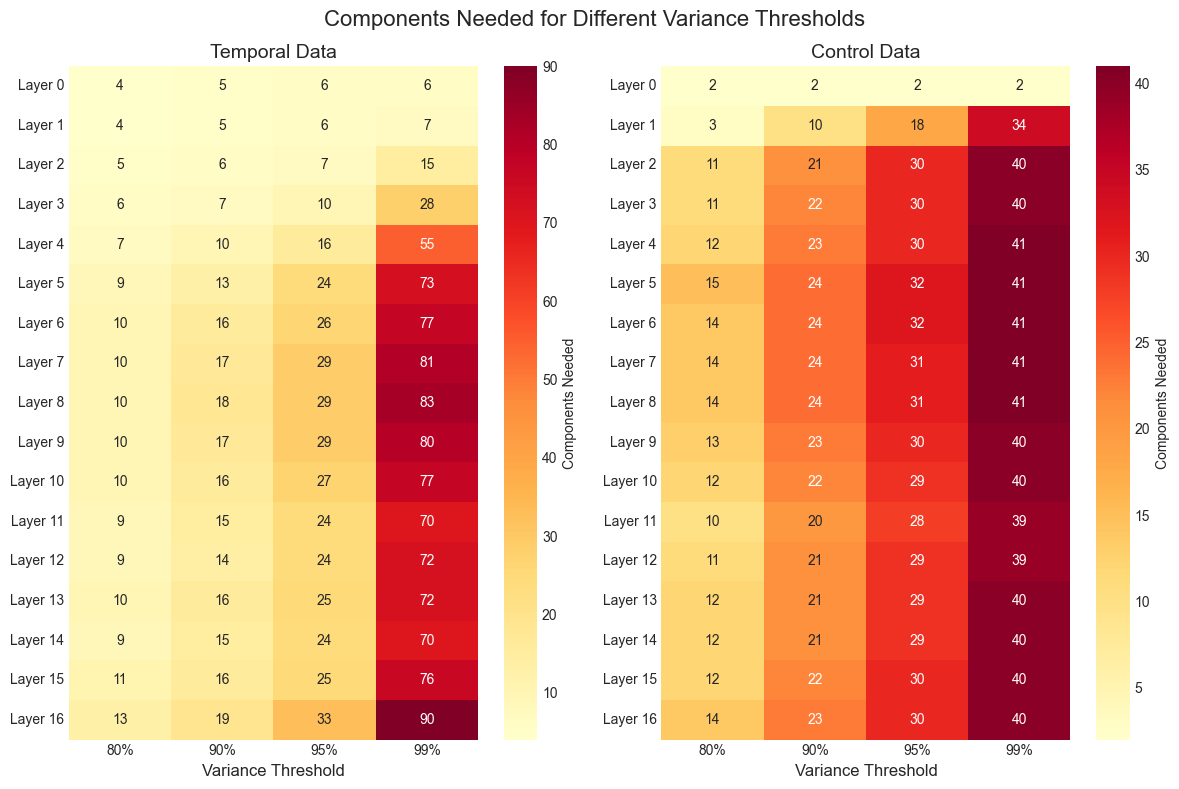

In [13]:
# Create heatmap data
thresholds = [0.80, 0.90, 0.95, 0.99]
heatmap_data_temporal = np.zeros((len(layers), len(thresholds)))
heatmap_data_control = np.zeros((len(layers), len(thresholds)))

for i, layer in enumerate(layers):
    for j, threshold in enumerate(thresholds):
        heatmap_data_temporal[i, j] = temporal_variance_results[layer]['components_needed'][threshold]
        heatmap_data_control[i, j] = control_variance_results[layer]['components_needed'][threshold]

# Create side-by-side heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

# Temporal heatmap
sns.heatmap(heatmap_data_temporal, 
            xticklabels=[f'{int(t*100)}%' for t in thresholds],
            yticklabels=[f'Layer {l}' for l in layers],
            annot=True, fmt='g', cmap='YlOrRd',
            ax=ax1, cbar_kws={'label': 'Components Needed'})
ax1.set_title('Temporal Data', fontsize=14)
ax1.set_xlabel('Variance Threshold', fontsize=12)

# Control heatmap
sns.heatmap(heatmap_data_control, 
            xticklabels=[f'{int(t*100)}%' for t in thresholds],
            yticklabels=[f'Layer {l}' for l in layers],
            annot=True, fmt='g', cmap='YlOrRd',
            ax=ax2, cbar_kws={'label': 'Components Needed'})
ax2.set_title('Control Data', fontsize=14)
ax2.set_xlabel('Variance Threshold', fontsize=12)

plt.suptitle('Components Needed for Different Variance Thresholds', fontsize=16)
plt.tight_layout()
plt.savefig('../../../results/figures/variance_analysis/components_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


In [14]:
# Compare temporal vs control at 95% variance
temporal_95 = summary_df['Temporal_95%'].values
control_95 = summary_df['Control_95%'].values

# Calculate differences
differences = control_95 - temporal_95
percent_differences = (differences / control_95) * 100

print("Difference in components needed (Control - Temporal) for 95% variance:")
print(f"Mean difference: {np.mean(differences):.2f} components")
print(f"Max difference: {np.max(differences):.2f} components (Layer {np.argmax(differences)})")
print(f"Min difference: {np.min(differences):.2f} components (Layer {np.argmin(differences)})")
print(f"\nMean percent difference: {np.mean(percent_differences):.1f}%")

# Find layers where temporal data is most compressed
temporal_compression = summary_df['Temporal_Ratio_95%'].values
best_compression_layers = np.argsort(temporal_compression)[:3]
print(f"\nLayers with best temporal compression (fewest components relative to dimension):")
for layer in best_compression_layers:
    print(f"  Layer {layer}: {temporal_compression[layer]*100:.1f}% of dimensions needed")

# Statistical test
from scipy import stats
t_stat, p_value = stats.ttest_rel(temporal_95, control_95)
print(f"\nPaired t-test (temporal vs control components at 95%):")
print(f"  t-statistic: {t_stat:.3f}")
print(f"  p-value: {p_value:.3e}")
print(f"  Significant difference: {'Yes' if p_value < 0.05 else 'No'}")


Difference in components needed (Control - Temporal) for 95% variance:
Mean difference: 6.24 components
Max difference: 23.00 components (Layer 2)
Min difference: -4.00 components (Layer 0)

Mean percent difference: 11.3%

Layers with best temporal compression (fewest components relative to dimension):
  Layer 0: 0.3% of dimensions needed
  Layer 1: 0.3% of dimensions needed
  Layer 2: 0.3% of dimensions needed

Paired t-test (temporal vs control components at 95%):
  t-statistic: -3.521
  p-value: 2.836e-03
  Significant difference: Yes


In [15]:
# Save detailed results
results_to_save = {
    'temporal_variance_results': temporal_variance_results,
    'control_variance_results': control_variance_results,
    'summary_df': summary_df,
    'config': config
}

with open('../../../results/data/variance_analysis_results.pkl', 'wb') as f:
    pickle.dump(results_to_save, f)

# Save summary CSV
summary_df.to_csv('../../../results/data/variance_analysis_summary.csv', index=False)

print("Results saved to:")
print("  - results/data/variance_analysis_results.pkl")
print("  - results/data/variance_analysis_summary.csv")
print("  - results/html/variance_explained_interactive.html")
print("  - results/figures/variance_analysis/")


Results saved to:
  - results/data/variance_analysis_results.pkl
  - results/data/variance_analysis_summary.csv
  - results/html/variance_explained_interactive.html
  - results/figures/variance_analysis/


In [16]:
print("=== KEY FINDINGS ===")
print("\n1. DIMENSIONALITY REQUIREMENTS FOR 95% VARIANCE:")
print(f"   - Temporal data: {np.mean(temporal_95):.1f} ± {np.std(temporal_95):.1f} components")
print(f"   - Control data: {np.mean(control_95):.1f} ± {np.std(control_95):.1f} components")
print(f"   - Temporal data requires {np.mean(percent_differences):.1f}% fewer components on average")

print("\n2. LAYER-WISE PATTERNS:")
print(f"   - Best temporal compression: Layers {best_compression_layers}")
print(f"   - Embedding dimension: {summary_df['Embedding_Dim'].iloc[0]} across all layers")

print("\n3. VARIANCE CONCENTRATION:")
first_pc_temp = np.mean([temporal_variance_results[l]['variance_ratios'][0] for l in layers]) * 100
first_pc_ctrl = np.mean([control_variance_results[l]['variance_ratios'][0] for l in layers]) * 100
print(f"   - First PC explains {first_pc_temp:.1f}% variance (temporal) vs {first_pc_ctrl:.1f}% (control)")
print(f"   - Temporal data shows more concentrated variance structure")

print("\n4. IMPLICATIONS:")
print("   - Temporal embeddings have more structured, lower-dimensional representations")
print("   - The circular manifold structure leads to efficient variance concentration")
print("   - Control words require more dimensions due to less structured distribution")


=== KEY FINDINGS ===

1. DIMENSIONALITY REQUIREMENTS FOR 95% VARIANCE:
   - Temporal data: 21.4 ± 8.6 components
   - Control data: 27.6 ± 7.1 components
   - Temporal data requires 11.3% fewer components on average

2. LAYER-WISE PATTERNS:
   - Best temporal compression: Layers [0 1 2]
   - Embedding dimension: 2048 across all layers

3. VARIANCE CONCENTRATION:
   - First PC explains 20.6% variance (temporal) vs 43.2% (control)
   - Temporal data shows more concentrated variance structure

4. IMPLICATIONS:
   - Temporal embeddings have more structured, lower-dimensional representations
   - The circular manifold structure leads to efficient variance concentration
   - Control words require more dimensions due to less structured distribution
